# Calculate spatial emissions

This tutorial is a full example how to calculate spatial emissions for BGT-soilmap combinations based on modelled emission data. We will use the data from the previous [coverage](./coverage.ipynb) and [flux](./flux.ipynb) examples in the same area.

Normally, running `lusos` also includes loading the BGT, soilmap and emissions data from files, which
will also be part of this tutorial. Each function to load lusos sample data also has an option to 
return filepaths instead of the actual data objects. We will set each of them to `True` to show the
way data is typically loaded to run lusos. Mainly for the soilmap data must be loaded in a specific way. This is normally distributed in a Geopackage format and loading the data requires to combine
information from several layers. Lusos has a dedicated `io` function to do this. The other data
sources can be loaded with normal Geopandas `read` functions. First, we will get the filepaths, load the data, and define the grid.

In [ ]:
import geopandas as gpd
import xarray as xr

import lusos

bgt_path = lusos.data.sample_bgt(as_path=True)
soilmap_path = lusos.data.sample_soilmap(as_path=True)
emissions_path = lusos.data.sample_emissions(as_path=True)

# Load data
soilmap = lusos.io.read_soilmap_geopackage(soilmap_path)
bgt = gpd.read_parquet(bgt_path)
emissions = gpd.read_parquet(emissions_path)

# Grid definition
xresolution = yresolution = 25
xmin, ymin, xmax, ymax = 111_000, 455_000, 116_000, 460_000
grid = lusos.LassoGrid(xmin, ymin, xmax, ymax, xresolution, yresolution)

First, we do the necessary preprocessing of the emissions data again.

In [2]:
emissions.columns = emissions.columns.str.lower()
emissions.rename(columns={"emission_t": "median"}, inplace=True)

Now we have the data loaded and the grid defined, we can calculate the spatial coverages of BGT-soilmap combinations and GHG fluxes

In [3]:
coverage = lusos.bgt_soilmap_coverage(bgt, soilmap, grid)
flux = lusos.calculate_somers_emissions(emissions, grid) # flux per m2

c:\src\lulucf-somers\.pixi\envs\default\Lib\site-packages\xugrid\regrid\structured.py:606: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.merge([ds_x, ds_y])
c:\src\lulucf-somers\.pixi\envs\default\Lib\site-packages\xugrid\regrid\structured.py:606: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds = xr.merge([ds_x, ds_y])
c:\src

The idea is to assign an emission value based for every cell in the example area. However, when we plot the calculated flux, we see that not every cell has data. This is because in this example, we use modelled CO2 emission (i.e. an out flux of CO2) from [SOMERS](https://www.nobveenweiden.nl/wp-content/uploads/2024/11/rapportage-SOMERS-2.0-technische-beschrijving.pdf), which only has data for the BGT type "percelen". Therefore, we can only assign these modelled values to certain cells that have combination "percelen-{some soilmap type}".

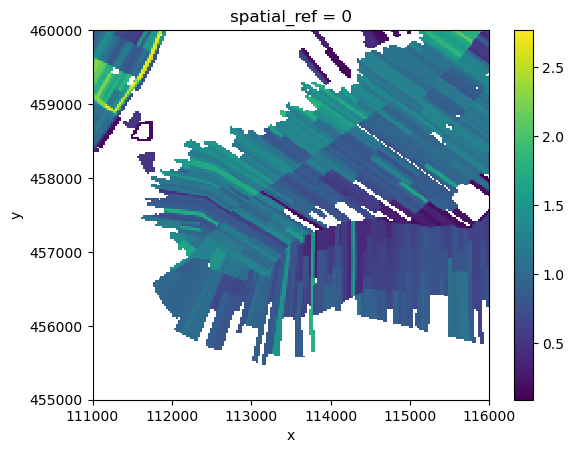

In [4]:
flux.plot.imshow()

We need to fill the missing values in another way. For this, lusos has emission factors available for BGT-soilmap combinations that we can use for the missing values. Our example area is situated in the "low-Netherlands". We can load emission factors for this.

In [5]:
ef_factors = lusos.data.ef_low_netherlands()
print(ef_factors.shape)
ef_factors.head()

(36, 4)


,co2_uit,ch4_uit,n2o_uit,co2_in
layer,,,,
panden_peat,1.025,0.0,0,0
overig_groen_peat,1.025,0.0,0,0
percelen_peat,1.025,0.0,0,0
openbare_ruimte_peat,1.025,0.0,0,0
grote_wateren_peat,0.000,0.0,0,0


We can multiply these emission factors with the coverage percentages and the cell area to get the flux per BGT-soilmap combination in each cell based on the emission factors. The result has a flux value for every x,y-location.

In [6]:
flux_ef_factors = coverage * ef_factors.loc[coverage["layer"], "co2_uit"].values[None, None, :]

KeyError: "['percelen_buried_deep', 'overig_groen_buried_deep', 'stedelijk_groen_buried_deep', 'openbare_ruimte_buried_deep', 'panden_buried_deep', 'erven_buried_deep', 'sloten_buried_deep', 'grote_wateren_buried_deep', 'overig_buried_deep'] not in index"

We need to combine these fluxes with the previously calculated SOMERS fluxes. To do this, we must make sure that we do not double count the BGT-soilmap combinations that contain "percelen". However, we still need to include the cells that contain any of those combinations but do not have a modelling result from SOMERS. We can do this in the steps shown below:

1. Sum the fluxes of BGT-soilmap combinations that contain "percelen".
2. Combine with the summed fluxes with the SOMERS fluxes -> take the SOMERS fluxes when available, otherwise take the summed flux.
3. Sum the fluxes of the remaining BGT-soilmap combinations and add these to the result of step 2.

In [ ]:
# Step 1
flux_parcels = flux_ef_factors.sel(layer=coverage["layer"].str.contains("percelen")).sum(dim="layer")

# Step 2
flux = xr.where(flux > 0, flux, flux_parcels)

# Step 3
flux_others = flux_ef_factors.sel(layer=~coverage["layer"].str.contains("percelen")).sum(dim="layer")
flux_total = flux + flux_others

flux_total.plot.imshow()

The resulting grid is now a weighted average greenhouse gas flux based on the contributions of BGT-soilmap combinations and SOMERS modelling results.